# **Analysis of results**

## **Libraries**

In [1]:
#%pip install pandas matplotlib seaborn

In [2]:
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import constants

## **Directories**

(Change the log file to automatically make new directories and plots).

In [3]:
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER
INSPECTED_FOLDER = constants.INSPECTED_DATA_FOLDER

CHECKPOINTS_100_LOG_FILENAME = 'checkpoints_es_gn.log'# 'split_tok_150_checkpoint_100.log' #'dev_checkpoint_100.log' #
CHECKPOINT_100_LOG_FILEPATH = os.path.join(INSPECTED_FOLDER, CHECKPOINTS_100_LOG_FILENAME)
CHECKPOINTS_100_RESULTS_FOLDER = os.path.join(RESULTS_FOLDER, 'checkpoints_100')
CURRENT_RESULTS_FOLDER = os.path.join(CHECKPOINTS_100_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME.split('.')[0])

if not os.path.exists(CHECKPOINTS_100_RESULTS_FOLDER):
    os.makedirs(CHECKPOINTS_100_RESULTS_FOLDER)

if not os.path.exists(CURRENT_RESULTS_FOLDER):
    os.makedirs(CURRENT_RESULTS_FOLDER)

## **Log format**

### **Log parsing**

In [4]:
log_lines = []
with open(CHECKPOINT_100_LOG_FILEPATH, 'r') as f:
    log_lines = f.readlines()

In [5]:
log_lines[-60:-50]

['[2023-06-03 16:16:03] [valid] References contain unknown word, metric scores may be inaccurate\n',
 "[2023-06-03 16:16:03] [valid] First sentence's tokens as scored:\n",
 '[2023-06-03 16:16:03] [valid] DefaultVocab keeps original segments for scoring\n',
 "[2023-06-03 16:16:03] [valid]   Hyp: Koâ€™agÌƒaitÃ©ramo mitÃ£nguÃ©ra ha umi mbaâ€™e oikÃ³va ko situaciÃ³n ikatu haguÃ£ umi demanda oÃ¯va en forma oÃ®va en forma pÃºblicas pÃ©va ko'Ã£ tendÃ¡re ha oimehÃ¡pe umi oÃ¯va carretera UpÃ©pe ojapÃ³va umi tekove rape ojejuhÃºva ko'Ã£ tÃ¡va guasu guasu rupi ha umi tÃ©ra ojejapÃ³va umi tenda upÃ©rÃµ aty guasu oÃ¯va jave ha â€œ pÃ©icha ikatu haguÃ£ oimÃ©va en general tÃ¡va guasu ha ojogua ysyry rehegua oiko jave ko'Ã£ mba'e rehe ha upÃ©va rupi mÃ¡va ha oÃ® rire umi mbaâ€™e vaiete aty ndive ojapÃ³va umi tetÃ£ ha orekÃ³va â€œ orekÃ³va umi mba'e vai en general rupi ha umi mba'e ikatÃºva ojapÃ³va en general rupi ha â€œ ojogua hikuÃ¡i peteÃ® Ã±eâ€™Ãªme oÃ¯va ha ko'Ãªme gotyo oiko jave umi korapy ndiv

The format of log files is: 

```[DATE] [valid] Ep. <METRIC_0> : <VALUE_0> ... <METRIC_n> : <VALUE_n> : (stalled n times|new best)\n```

In [6]:
log_regex = r'''
    \[(\d{4})-(\d{2})-(\d{2})\s(\d{2}):(\d{2}):(\d{2})\]\s
    \[valid\]\s
    Ep\.\s(\S+)\s:\s
    Up\.\s(\S+)\s
    (?::\s(\S+)\s:\s(\S+))+\s
    :\s(.+)
'''
log_regex = re.compile(log_regex, re.VERBOSE)

In [7]:
def parse_line_groups(lines, regex):
    # type: (list[str], re.Pattern) -> list[tuple[str, str, str, str, str, str]]
    line_groups = []

    for line in lines:
        match = regex.match(line)
        if match:
            line_groups.append(match.groups()) 

    return line_groups   

In [8]:
lines = parse_line_groups(log_lines, log_regex)
[' '.join(lines for lines in line_group) for line_group in lines[30:35]]

['2023 06 03 15 05 57 61 17795 bleu 1.80302 stalled 1 times (last best: 1.88328)',
 '2023 06 03 15 09 10 61 17795 chrf 22.1177 stalled 1 times (last best: 22.2402)',
 '2023 06 03 15 09 16 61 17795 cross-entropy 112.13 stalled 6 times (last best: 82.5544)',
 '2023 06 03 15 09 22 61 17795 perplexity 1927.86 stalled 6 times (last best: 262.175)',
 '2023 06 03 15 09 28 61 17795 valid-script 0 stalled 6 times (last best: 0)']

### **Convert log to dataframe**

In [9]:
def create_log_dataframe(parsed_lines, debug=False):
    # type: (list[tuple[str, str, str, str, str, str]], bool) -> pd.DataFrame
    log_by_epoch = dict()
    seen_epochs = set()
    static_columns = ['index', 'epoch', 'year', 'month', 'day', 'hour', 'minute', 'second', 'update', 'status']
    for column in static_columns:
        log_by_epoch[column] = []

    for idx, line in enumerate(parsed_lines):
        year, month, day,\
        hour, minute, second,\
        epoch, update,\
        metric, metric_value,\
        status = line

        static_values_to_append = [idx, epoch, year, month, day, hour, minute, second, update, status]

        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            for column, value in zip(static_columns, static_values_to_append):
                log_by_epoch[column].append(value)

        if metric not in log_by_epoch:
            log_by_epoch[metric] = []
        log_by_epoch[metric].append(metric_value)

    if debug:
        print('seen epochs: {}'.format(seen_epochs))
    
    return pd.DataFrame(log_by_epoch)

In [10]:
log_dataframe = create_log_dataframe(lines)

In [11]:
log_dataframe

,index,epoch,year,month,day,hour,minute,second,update,status,bleu,chrf,cross-entropy,perplexity,valid-script
0,0,11,2023,06,03,13,48,54,2968,new best,0.366136,13.6007,82.5544,262.175,0
1,5,21,2023,06,03,14,02,41,5933,new best,0.896242,17.7051,83.3085,275.857,0
2,10,31,2023,06,03,14,16,47,8898,new best,1.1521,18.771,88.1826,383.248,0
3,15,34,2023,06,03,14,26,24,10000,new best,1.33489,19.8979,90.9317,461.338,0
4,20,41,2023,06,03,14,37,37,11864,new best,1.5012,20.8086,95.8422,642.513,0
5,25,51,2023,06,03,14,51,50,14829,new best,1.88328,22.2401,104.214,1130.2,0
6,30,61,2023,06,03,15,05,57,17795,stalled 1 times (last best: 1.88328),1.80302,22.1177,112.13,1927.86,0
7,35,68,2023,06,03,15,18,30,20000,stalled 2 times (last best: 1.88328),1.72417,22.2982,117.622,2792.27,0
8,40,71,2023,06,03,15,27,12,20760,stalled 3 times (last best: 1.88328),1.83072,22.5977,119.293,3125.52,0
9,45,81,2023,06,03,15,42,00,23727,new best,1.8954,22.6424,125.91,4884.06,0


In [12]:
log_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          19 non-null     int64 
 1   epoch          19 non-null     object
 2   year           19 non-null     object
 3   month          19 non-null     object
 4   day            19 non-null     object
 5   hour           19 non-null     object
 6   minute         19 non-null     object
 7   second         19 non-null     object
 8   update         19 non-null     object
 9   status         19 non-null     object
 10  bleu           19 non-null     object
 11  chrf           19 non-null     object
 12  cross-entropy  19 non-null     object
 13  perplexity     19 non-null     object
 14  valid-script   19 non-null     object
dtypes: int64(1), object(14)
memory usage: 2.4+ KB


<font color='orange'>*Obs:* All the columns have object Dtype</font>

In [13]:
categorical_columns = ['status']
numerical_columns = [col for col in log_dataframe.columns if col not in categorical_columns]
log_dataframe[numerical_columns] = log_dataframe[numerical_columns].astype(float)

In [14]:
log_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          19 non-null     float64
 1   epoch          19 non-null     float64
 2   year           19 non-null     float64
 3   month          19 non-null     float64
 4   day            19 non-null     float64
 5   hour           19 non-null     float64
 6   minute         19 non-null     float64
 7   second         19 non-null     float64
 8   update         19 non-null     float64
 9   status         19 non-null     object 
 10  bleu           19 non-null     float64
 11  chrf           19 non-null     float64
 12  cross-entropy  19 non-null     float64
 13  perplexity     19 non-null     float64
 14  valid-script   19 non-null     float64
dtypes: float64(14), object(1)
memory usage: 2.4+ KB


In [15]:
inspected_filename = CHECKPOINTS_100_LOG_FILENAME.split('.')[0]
log_dataframe.to_csv(os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_log_dataframe.csv'))

## **Log analysis**

### **Metrics**

In [16]:
def plot_metrics_by_epoch(dataframe, metrics, save_path=None):
    num_metrics = len(metrics)
    
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(ncols=num_metrics, figsize=(4*num_metrics, 4))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(x='epoch', y=metric, data=dataframe, ax=ax)
        ax.set_title(metric)

        highest_value = dataframe[metric].max()
        max_index = dataframe[dataframe[metric] == highest_value]['epoch'].values[0]
        ax.plot(max_index, highest_value, marker='o', markersize=8, color='red')
        ax.text(0, highest_value, f'Epoch: {int(max_index-1)} \n Max: {highest_value:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.tight_layout()
    plt.savefig(save_path) if save_path is not None else plt.show()

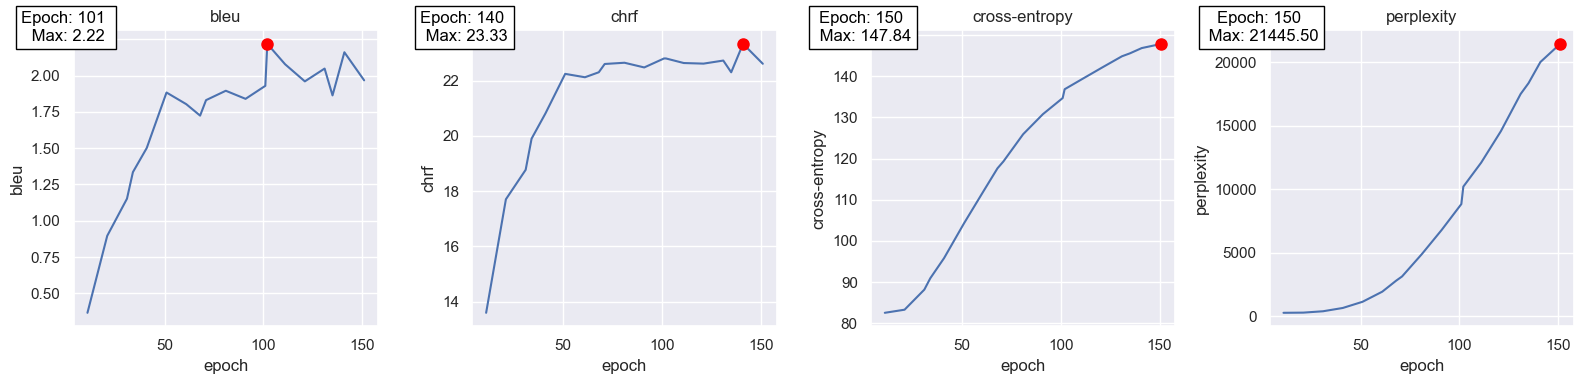

In [17]:
metrics = ['bleu', 'chrf', 'cross-entropy', 'perplexity']
save_path = os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_metrics.png')
plot_metrics_by_epoch(log_dataframe, metrics, save_path=save_path)

In [18]:
log_dataframe.describe()

,index,epoch,year,month,day,hour,minute,second,update,bleu,chrf,cross-entropy,perplexity,valid-script
count,19.000000,19.000000,19.0,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,45.000000,81.789474,2023.0,6.0,3.0,15.210526,29.315789,35.894737,23995.894737,1.707995,21.417800,120.460337,7665.997421,0.0
std,28.136572,43.284048,0.0,0.0,0.0,1.182227,17.473957,17.194620,12841.774366,0.470213,2.412325,23.307238,7529.043739,0.0
min,0.000000,11.000000,2023.0,6.0,3.0,13.000000,2.000000,0.000000,2968.000000,0.366136,13.600700,82.554400,262.175000,0.0
25%,22.500000,46.000000,2023.0,6.0,3.0,14.000000,17.000000,25.000000,13346.500000,1.612685,21.463150,100.028100,886.356500,0.0
50%,45.000000,81.000000,2023.0,6.0,3.0,15.000000,27.000000,37.000000,23727.000000,1.863460,22.472500,125.910000,4884.060000,0.0
75%,67.500000,116.000000,2023.0,6.0,3.0,16.000000,43.500000,49.500000,34110.500000,1.963615,22.637250,140.723500,13324.650000,0.0
max,90.000000,151.000000,2023.0,6.0,3.0,17.000000,59.000000,57.000000,44493.000000,2.218370,23.325300,147.843000,21445.500000,0.0


### **Time**

In [19]:
def add_time_diff(dataframe):
    # type: (pd.DataFrame) -> pd.DataFrame
    dataframe['datetime'] = pd.to_datetime(dataframe[['year', 'month', 'day', 'hour', 'minute', 'second']])
    dataframe['time_diff'] = dataframe['datetime'].diff()
    return dataframe

In [20]:
log_dataframe = add_time_diff(log_dataframe)

In [21]:
log_dataframe['time_diff']

0                NaT
1    0 days 00:13:47
2    0 days 00:14:06
3    0 days 00:09:37
4    0 days 00:11:13
5    0 days 00:14:13
6    0 days 00:14:07
7    0 days 00:12:33
8    0 days 00:08:42
9    0 days 00:14:48
10   0 days 00:14:37
11   0 days 00:14:42
12   0 days 00:07:30
13   0 days 00:12:46
14   0 days 00:14:12
15   0 days 00:14:10
16   0 days 00:10:29
17   0 days 00:10:26
18   0 days 00:14:16
Name: time_diff, dtype: timedelta64[ns]

In [22]:
log_dataframe['time_diff'].describe()

count                           18
mean     0 days 00:12:34.111111111
std      0 days 00:02:18.737962440
min                0 days 00:07:30
25%                0 days 00:10:40
50%         0 days 00:13:56.500000
75%         0 days 00:14:12.750000
max                0 days 00:14:48
Name: time_diff, dtype: object

In [23]:
def plot_time_diff(dataframe, index, value, save_path=None):
    sns.set(style='darkgrid')
    index = [int(i) for i in dataframe[index].values]
    sns.barplot(x=index, y=value, data=dataframe, palette='Blues_d')

    for index, row in dataframe.iterrows():
        text_value = str(row['time_diff']).split(' ')[-1]
        text_value = text_value.split(':')[1:]
        text_value = ':'.join(text_value)
        plt.text(index, row['time_diff_sec'], text_value, ha='center', va='bottom', fontsize=8)

    mean = dataframe['time_diff_sec'].mean()
    std = dataframe['time_diff_sec'].std()
    plt.axhline(mean, color='#FF8C00', linestyle='--', label='Mean')
    #plt.axhspan(mean - std, mean + std, facecolor='orange', alpha=0.3, label='Deviation')
    mean_text = '{}:{}'.format(int(mean) // 60, int(mean % 60))
    plt.text(0, mean, mean_text, ha='center', va='bottom')

    plt.xlabel('Index')
    plt.ylabel('Time Difference (seconds)')
    plt.title('Time Differences between Consecutive Tuples')
    plt.savefig(save_path) if save_path is not None else plt.show()

In [24]:
log_dataframe['time_diff_sec'] = log_dataframe['time_diff'].dt.total_seconds()

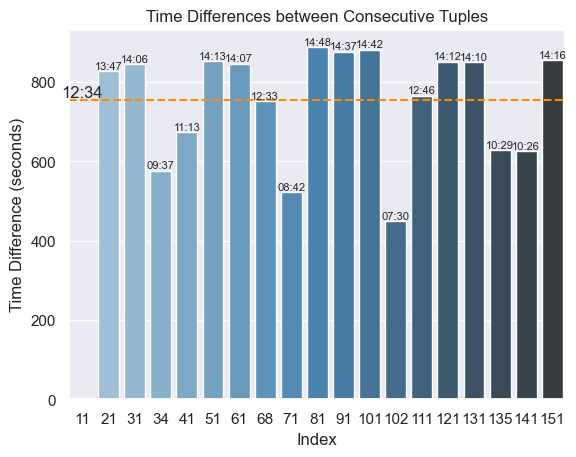

In [25]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_time_diff.png')
plot_time_diff(log_dataframe, 'epoch', 'time_diff_sec', save_path=save_path)

<font color='orange'>*Obs:* There are 3 outliers that shouldn't be there...</font>

### **Time taken by metrics**

In [26]:
log_time_regex = r'''
    \[(\d{4})-(\d{2})-(\d{2})\s(\d{2}):(\d{2}):(\d{2})\]\s
    \[valid\]\s
    (.+)
'''

log_time_regex = re.compile(log_time_regex, re.VERBOSE)

In [27]:
time_lines = parse_line_groups(log_lines, log_time_regex)

In [28]:
' '.join(time_lines[0])

'2023 06 03 13 46 07 References contain unknown word, metric scores may be inaccurate'

In [29]:
def create_log_metric_dataframe(parsed_lines, debug=False):
    # type: (list[tuple[str, str, str, str, str, str]], bool) -> pd.DataFrame
    log = dict()
    static_columns = ['index', 'year', 'month', 'day', 'hour', 'minute', 'second', 'rest']
    for column in static_columns:
        log[column] = []

    for idx, line in enumerate(parsed_lines):
        static_values_to_append = [idx, *line]
        for column, value in zip(static_columns, static_values_to_append):
            log[column].append(value)

    if debug:
        print('seen epochs: {}'.format(log))
    
    return pd.DataFrame(log)

In [30]:
log_metric_dataframe = create_log_metric_dataframe(time_lines)

In [31]:
log_metric_dataframe.head()

,index,year,month,day,hour,minute,second,rest
0,0,2023,06,03,13,46,07,"References contain unknown word, metric scores..."
1,1,2023,06,03,13,46,07,First sentence's tokens as scored:
2,2,2023,06,03,13,46,07,DefaultVocab keeps original segments for scoring
3,3,2023,06,03,13,46,07,Hyp: PÃ©icha avei umi tapicha umi tapicha or...
4,4,2023,06,03,13,46,07,Ref: <unk> ko tape heta perhuisio ojapÃ³ma u...


In [32]:
log_metric_dataframe = add_time_diff(log_metric_dataframe)

In [33]:
log_metric_dataframe.tail()

,index,year,month,day,hour,minute,second,rest,datetime,time_diff
165,165,2023,06,03,17,35,08,Ep. 151 : Up. 44493 : bleu : 1.9672 : stalled ...,2023-06-03 17:35:08,0 days 00:03:12
166,166,2023,06,03,17,38,22,Ep. 151 : Up. 44493 : chrf : 22.6051 : stalled...,2023-06-03 17:38:22,0 days 00:03:14
167,167,2023,06,03,17,38,28,Ep. 151 : Up. 44493 : cross-entropy : 147.843 ...,2023-06-03 17:38:28,0 days 00:00:06
168,168,2023,06,03,17,38,35,Ep. 151 : Up. 44493 : perplexity : 21445.5 : s...,2023-06-03 17:38:35,0 days 00:00:07
169,169,2023,06,03,17,38,38,Ep. 151 : Up. 44493 : valid-script : 0 : stall...,2023-06-03 17:38:38,0 days 00:00:03


In [34]:
def create_metric_time_dataframe(dataframe, metrics, debug=False):
    # type: (pd.DataFrame, list[str], bool) -> pd.DataFrame
    metric_time_dataframe = {}
    for idx, row in dataframe.iterrows():
        for metric in metrics:
            if metric in row['rest']:
                metric_time_dataframe.setdefault(metric, [])
                metric_time_dataframe[metric].append(row['time_diff'])

    if debug:
        print('metric time dataframe: {}'.format(metric_time_dataframe))

    return pd.DataFrame(metric_time_dataframe)

In [35]:
time_metric_df = create_metric_time_dataframe(log_metric_dataframe, metrics)

In [36]:
time_metric_df.tail()

,bleu,chrf,cross-entropy,perplexity
14,0 days 00:03:05,0 days 00:03:11,0 days 00:00:06,0 days 00:00:07
15,0 days 00:02:57,0 days 00:03:02,0 days 00:00:06,0 days 00:00:06
16,0 days 00:03:13,0 days 00:03:21,0 days 00:00:07,0 days 00:00:06
17,0 days 00:06:49,0 days 00:02:58,0 days 00:00:07,0 days 00:00:06
18,0 days 00:03:12,0 days 00:03:14,0 days 00:00:06,0 days 00:00:07


In [37]:
time_metric_df.describe()

,bleu,chrf,cross-entropy,perplexity
count,19,19,19,19
mean,0 days 00:03:57.526315789,0 days 00:03:08,0 days 00:00:06.473684210,0 days 00:00:06.368421052
std,0 days 00:01:58.080654366,0 days 00:00:09.893881386,0 days 00:00:00.512989176,0 days 00:00:00.495594627
min,0 days 00:02:46,0 days 00:02:51,0 days 00:00:06,0 days 00:00:06
25%,0 days 00:02:59,0 days 00:02:59.500000,0 days 00:00:06,0 days 00:00:06
50%,0 days 00:03:08,0 days 00:03:11,0 days 00:00:06,0 days 00:00:06
75%,0 days 00:03:15,0 days 00:03:15.500000,0 days 00:00:07,0 days 00:00:07
max,0 days 00:09:39,0 days 00:03:21,0 days 00:00:07,0 days 00:00:07


In [38]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_time_by_metric.csv')
time_metric_df.to_csv(save_path)